# CAB420, Week 5 Practical, Question 1 Solution
# Fine-Tuning DCNNs. 
The Kuzushiji-MNIST-49 database, or K-MNIST-49, is a MNIST like database, though with a substantially larger number of classes. However while the number of classes and the variety within them is increased over MNIST, the characteristics of the images are largely the same, i.e. the database is made up of 28x28 pixel grey scale images, where pixel values are often close to 0 or 1 (i.e. black or white). Given this, a model trained on MNIST is likely to adapt well when fine-tuned on K-MNIST-49.

Using a model that has been trained on MNIST and the K-MNIST-49 dataset:
* Modify the network to classify 49 classes rather than the original 10;
* Fine-tune the network and assess the model’s performance. Consider how it compares to the models trained from scratch in the Week 4 practical.

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import scipy.io
import numpy

## The Data
As per last week, we'll use scipy.io.loadmat to get the data in.

We'll do the required reshape to get it into the format that keras wants, and then print a bit for a sanity check.

Note that as per the addendum to last weeks solution, we're going to use to_categorical to get the data into a one-hot vector form.

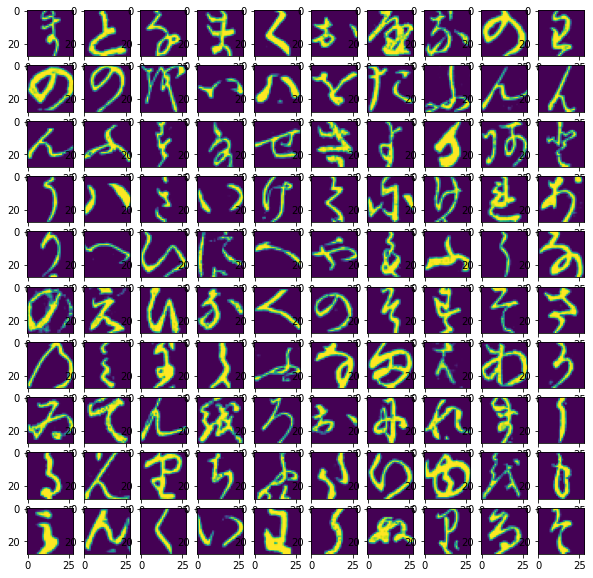

In [2]:
kmnist_train = scipy.io.loadmat('../../data/kmnist/kmnist49_train.mat')
kmnist_test = scipy.io.loadmat('../../data/kmnist/kmnist49_test.mat')
train = numpy.transpose(kmnist_train['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
train_y = to_categorical(kmnist_train['labels'], 49)
test = numpy.transpose(kmnist_test['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
test_y = to_categorical(kmnist_test['labels'], 49)

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])

## Fine Tuning

For completeness, and because it's easy, we'll tune a couple of different models. 

### Model 1

We'll start with a simple VGG model.

In [3]:
model = keras.models.load_model('../../trained_models_keras/vgg_2stage_MNIST_small.h5')
model.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
activation_17 (Activation)   (None, 28, 28, 8)         0         
_________________________________________________________________
spatial_dropout2d_10 (Spatia (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 8)         0

And swap out the last layer for a brand new dense layer, with 49 outputs (as we have 49 classes).

In [4]:
outputs = layers.Dense(49, activation='softmax')(model.layers[-2].output)
new_model = keras.Model(inputs=model.input, outputs=outputs)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
activation_17 (Activation)   (None, 28, 28, 8)         0         
_________________________________________________________________
spatial_dropout2d_10 (Spatia (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 8)         0     

We'll then lock off all the convolution layers, and tune just the Dense layers (the new one, and the one that was already there)

In [5]:
for layer in new_model.layers[:-5]:
    layer.trainable = False

for layer in new_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f421f1789b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f421f075c50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f421f1419e8> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f421f0c6978> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f421f087320> False
<tensorflow.python.keras.layers.core.SpatialDropout2D object at 0x7f421f087668> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f421f137be0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f421f07fe80> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f421f08a128> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f421fb6a748> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f421f01d400> False
<tensorflow.python.keras.layers.core.SpatialDrop

Now for training.

In [6]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history = new_model.fit(train, train_y,
                        batch_size=128,
                        epochs=10,
                        validation_data=(test, test_y))

Train on 232365 samples, validate on 38547 samples
Epoch 1/10
232365/232365 [==============================] - 20s 86us/sample - loss: 2.5108 - accuracy: 0.4008 - val_loss: 2.1599 - val_accuracy: 0.4929
Epoch 2/10
232365/232365 [==============================] - 21s 92us/sample - loss: 1.6761 - accuracy: 0.5895 - val_loss: 1.8253 - val_accuracy: 0.5604
Epoch 3/10
232365/232365 [==============================] - 19s 81us/sample - loss: 1.4234 - accuracy: 0.6449 - val_loss: 1.6303 - val_accuracy: 0.6031
Epoch 4/10
232365/232365 [==============================] - 20s 85us/sample - loss: 1.2712 - accuracy: 0.6795 - val_loss: 1.4964 - val_accuracy: 0.6329
Epoch 5/10
232365/232365 [==============================] - 20s 86us/sample - loss: 1.1609 - accuracy: 0.7056 - val_loss: 1.3956 - val_accuracy: 0.6562
Epoch 6/10
232365/232365 [==============================] - 19s 83us/sample - loss: 1.0804 - accuracy: 0.7255 - val_loss: 1.3164 - val_accuracy: 0.6750
Epoch 7/10
232365/232365 [===========

In [7]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(y_test, axis=1)

    cm = confusion_matrix(gt_idx, indexes)
    fig = plt.figure(figsize=[20, 20])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(49))
    c.plot(ax = ax)

    fig = plt.figure(figsize=[20, 5])
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(gt_idx, bins=len(numpy.diagonal(cm)), rwidth=0.95)
    ax.plot(numpy.diagonal(cm))

We can see performance looks ok.

38547/38547 - 3s - loss: 1.1073 - accuracy: 0.7217
Test loss: 1.1072601274633531
Test accuracy: 0.7216904


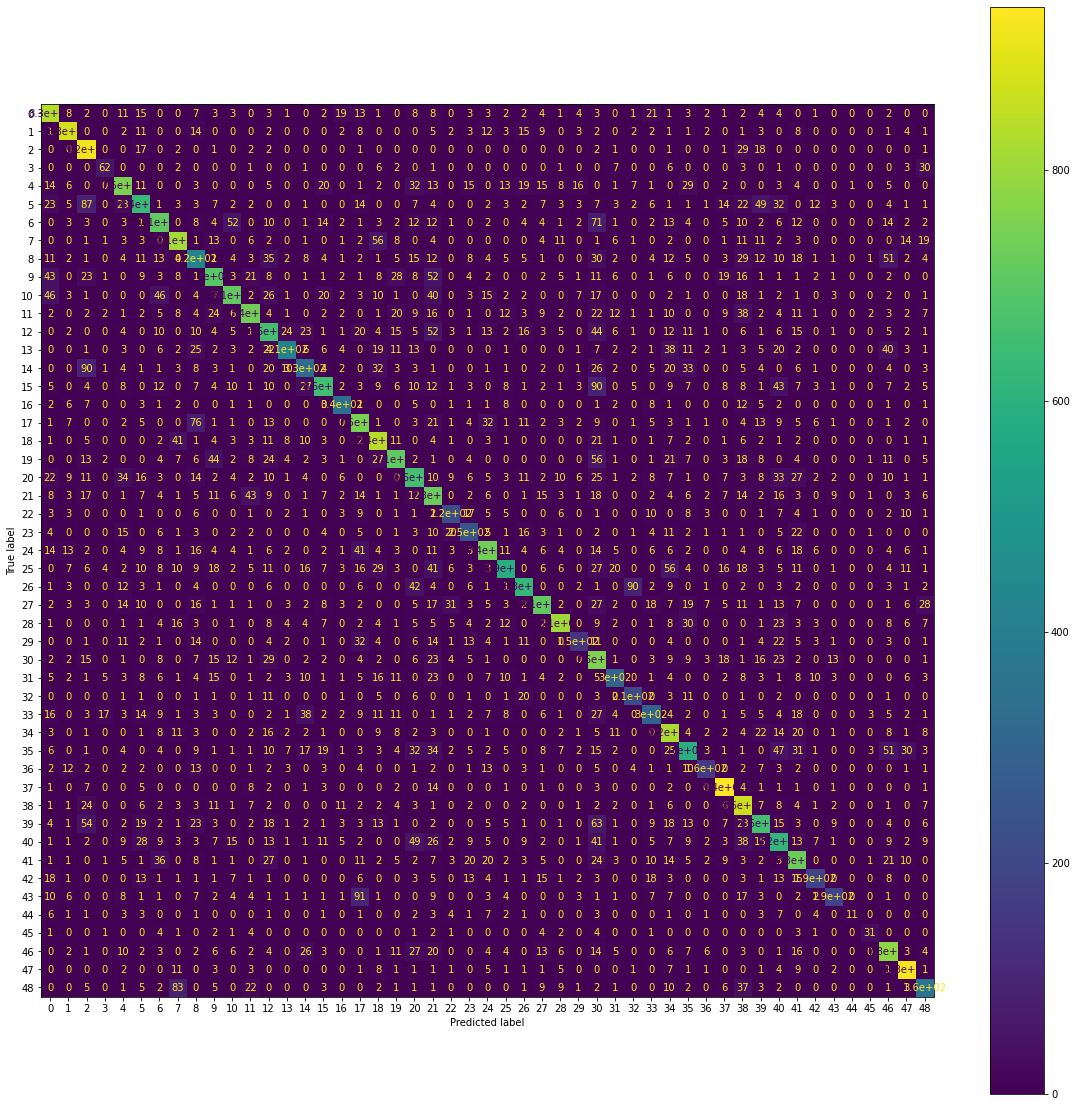

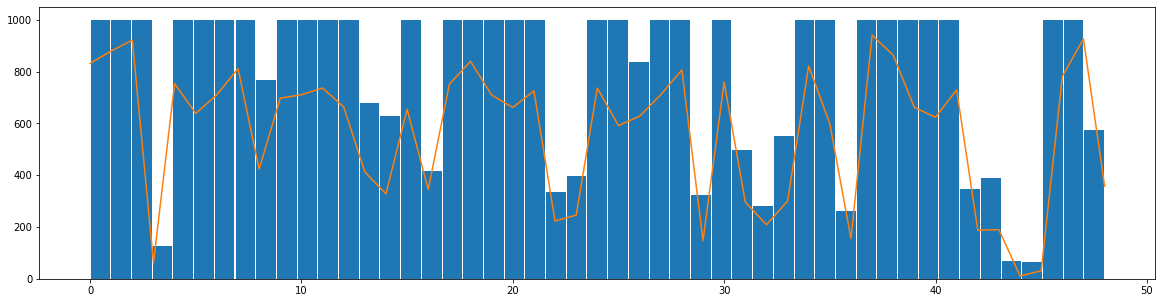

In [8]:
eval_model(new_model, test, test_y)

### Model 2 - A ResNet
For completeness, we'll tune up a different model. This time a simple ResNet. We'll follow the same process as the first time around. However this time we'll tune just the last layer as that is the only dense layer in the network.

In [9]:
model = keras.models.load_model('../../trained_models_keras/resnet_v1_MNIST_medium.h5')
model.summary()

Model: "medium_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 28, 28, 8)    80          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 28, 28, 8)    32          conv2d_109[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 28, 28, 8)    0           batch_normalization_95[0][0]     
___________________________________________________________________________________

In [10]:
outputs = layers.Dense(49, activation='softmax')(model.layers[-2].output)
new_model = keras.Model(inputs=model.input, outputs=outputs)
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 28, 28, 8)    80          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 28, 28, 8)    32          conv2d_109[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 28, 28, 8)    0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [11]:
# Freeze the layers except the last 1 layers
for layer in new_model.layers[:-1]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in new_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f41bc40d208> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f41bc40d2b0> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f41bc40d5f8> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f41bc40d710> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f41bc40d9e8> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f41bc40dc18> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f41bc40ddd8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f41bc40df98> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f41bc42d208> False
<tensorflow.python.keras.layers.merge.Add object at 0x7f41bc42d3c8> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f41bc42d588> False
<tensorflow.python.keras.layers.convolutional.Conv2D 

In [12]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history = new_model.fit(train, train_y,
                        batch_size=128,
                        epochs=10,
                        validation_data=(test, test_y))

Train on 232365 samples, validate on 38547 samples
Epoch 1/10
232365/232365 [==============================] - 45s 194us/sample - loss: 3.0920 - accuracy: 0.2530 - val_loss: 3.1927 - val_accuracy: 0.2119
Epoch 2/10
232365/232365 [==============================] - 47s 201us/sample - loss: 2.4941 - accuracy: 0.3991 - val_loss: 3.1211 - val_accuracy: 0.2294
Epoch 3/10
232365/232365 [==============================] - 44s 188us/sample - loss: 2.3406 - accuracy: 0.4316 - val_loss: 3.1075 - val_accuracy: 0.2350
Epoch 4/10
232365/232365 [==============================] - 44s 189us/sample - loss: 2.2585 - accuracy: 0.4502 - val_loss: 3.1148 - val_accuracy: 0.2376
Epoch 5/10
232365/232365 [==============================] - 44s 188us/sample - loss: 2.2023 - accuracy: 0.4639 - val_loss: 3.1064 - val_accuracy: 0.2468
Epoch 6/10
232365/232365 [==============================] - 45s 193us/sample - loss: 2.1605 - accuracy: 0.4732 - val_loss: 3.0978 - val_accuracy: 0.2489
Epoch 7/10
232365/232365 [=====

38547/38547 - 6s - loss: 3.0604 - accuracy: 0.2652
Test loss: 3.060441486955533
Test accuracy: 0.26523465


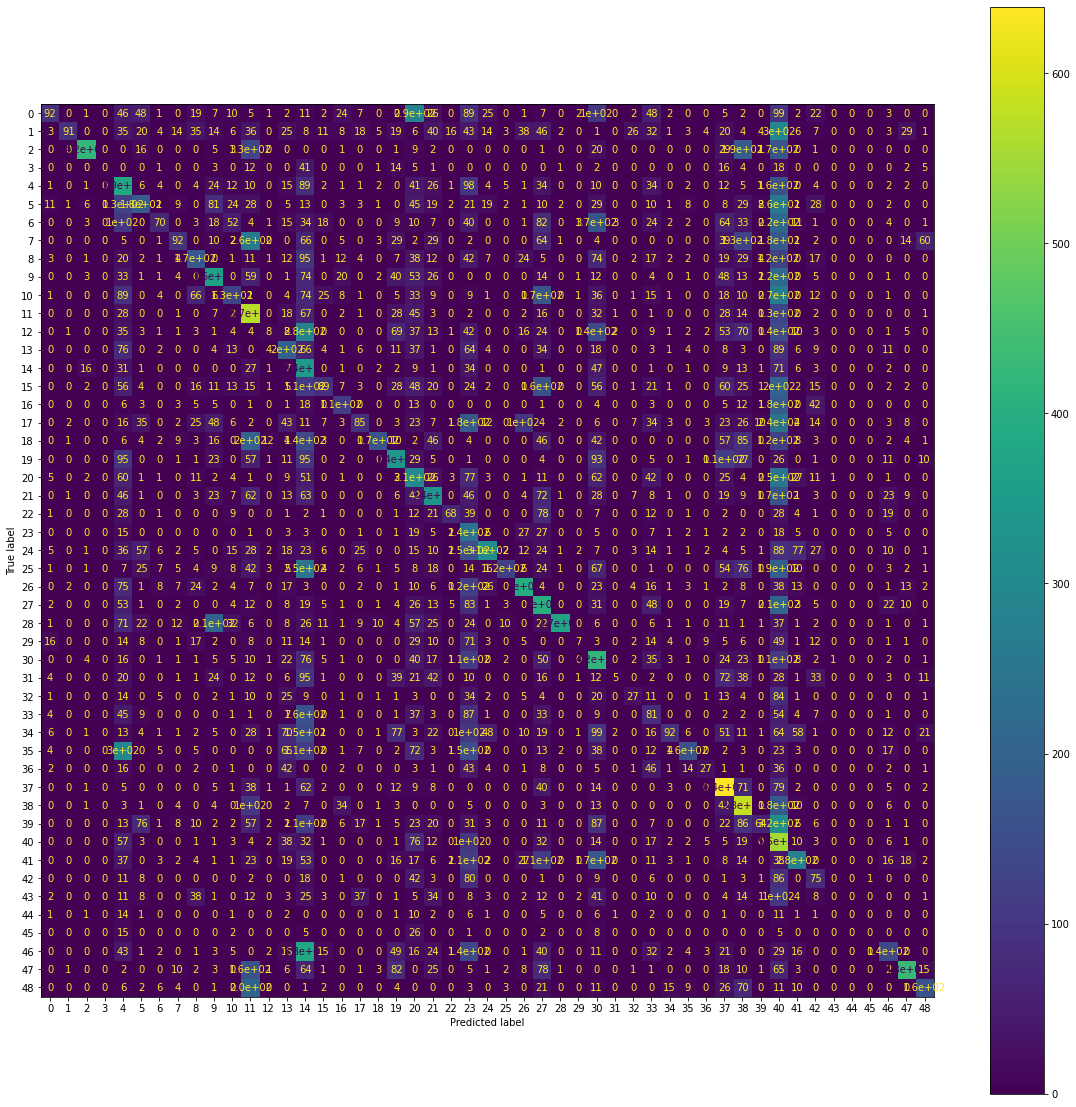

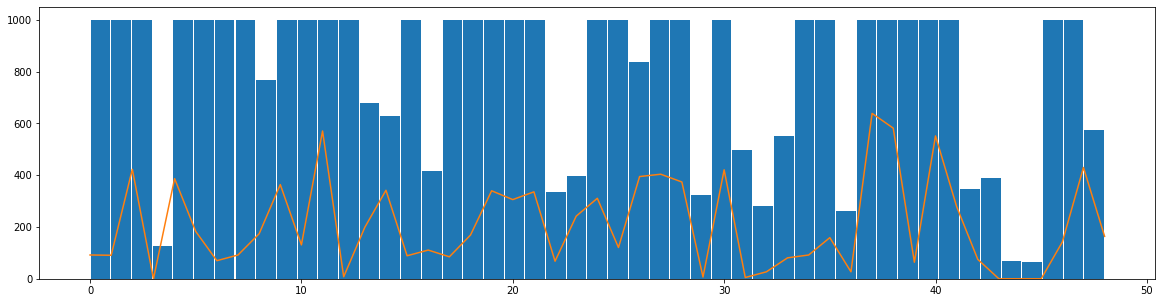

In [13]:
eval_model(new_model, test, test_y)

### Model 2A - The Same Resnet Again

For our ResNet, before we only tuned one layer. Let's tune the lot this time and see what happens. This will be the same as last time, we'll just leave out the bit where we freeze layer weights.

In [14]:
model = keras.models.load_model('../../trained_models_keras/resnet_v1_MNIST_medium.h5')
model.summary()

Model: "medium_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 28, 28, 8)    80          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 28, 28, 8)    32          conv2d_109[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 28, 28, 8)    0           batch_normalization_95[0][0]     
___________________________________________________________________________________

In [15]:
outputs = layers.Dense(49, activation='softmax')(model.layers[-2].output)
new_model = keras.Model(inputs=model.input, outputs=outputs)
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 28, 28, 8)    80          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 28, 28, 8)    32          conv2d_109[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 28, 28, 8)    0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

This time we'll tune the whole network.

In [16]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history = new_model.fit(train, train_y,
                        batch_size=128,
                        epochs=10,
                        validation_data=(test, test_y))

Train on 232365 samples, validate on 38547 samples
Epoch 1/10
232365/232365 [==============================] - 155s 666us/sample - loss: 2.2069 - accuracy: 0.4943 - val_loss: 1.9803 - val_accuracy: 0.5330
Epoch 2/10
232365/232365 [==============================] - 155s 667us/sample - loss: 1.1527 - accuracy: 0.7341 - val_loss: 1.5252 - val_accuracy: 0.6420
Epoch 3/10
232365/232365 [==============================] - 157s 675us/sample - loss: 0.7970 - accuracy: 0.8182 - val_loss: 1.2292 - val_accuracy: 0.7120
Epoch 4/10
232365/232365 [==============================] - 156s 673us/sample - loss: 0.6191 - accuracy: 0.8575 - val_loss: 1.0310 - val_accuracy: 0.7446
Epoch 5/10
232365/232365 [==============================] - 157s 677us/sample - loss: 0.5180 - accuracy: 0.8805 - val_loss: 0.9213 - val_accuracy: 0.7741
Epoch 6/10
232365/232365 [==============================] - 157s 677us/sample - loss: 0.4512 - accuracy: 0.8954 - val_loss: 0.8761 - val_accuracy: 0.7863
Epoch 7/10
232365/232365 

38547/38547 - 6s - loss: 0.6903 - accuracy: 0.8279
Test loss: 0.6903375012913507
Test accuracy: 0.8278984


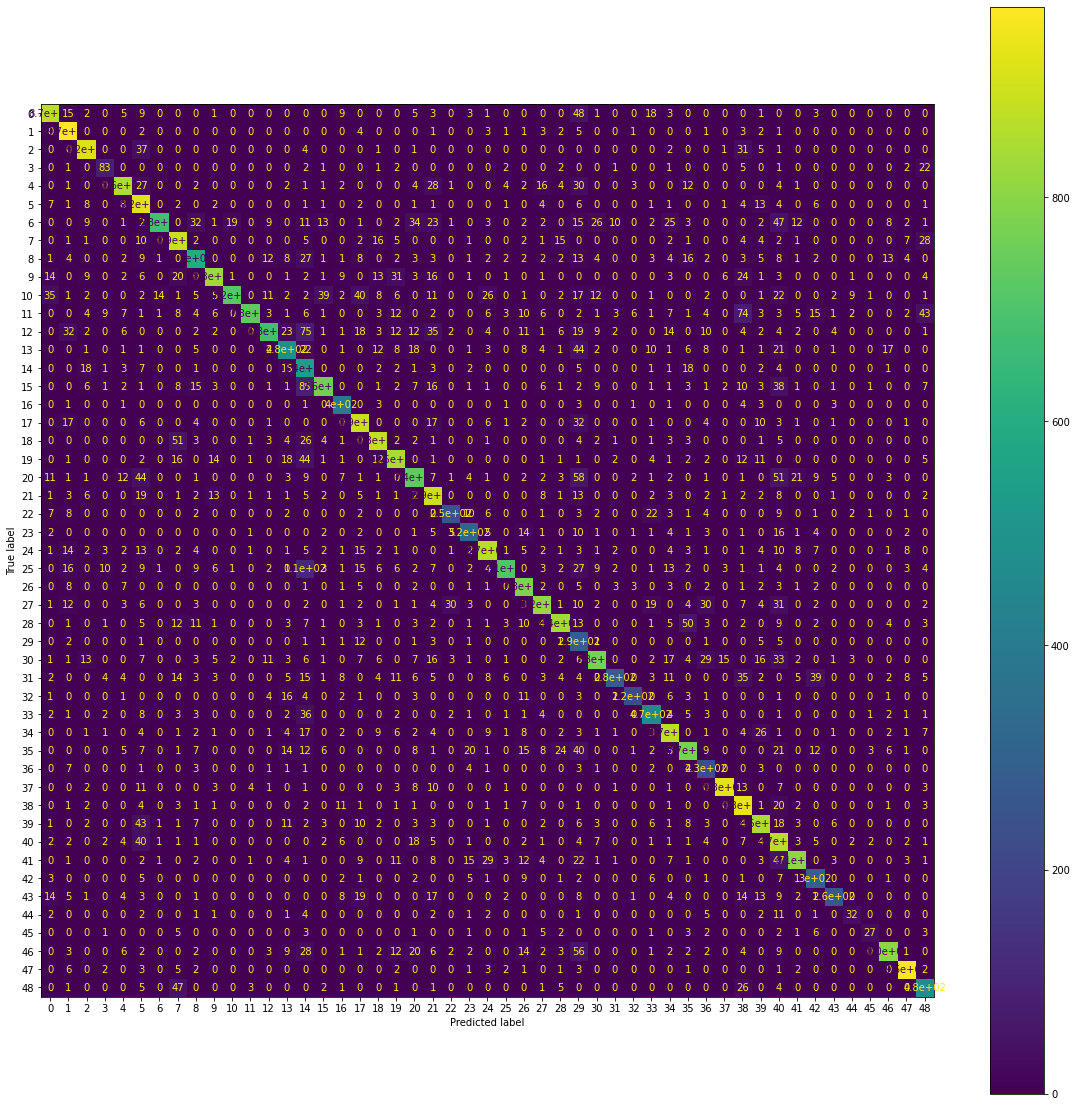

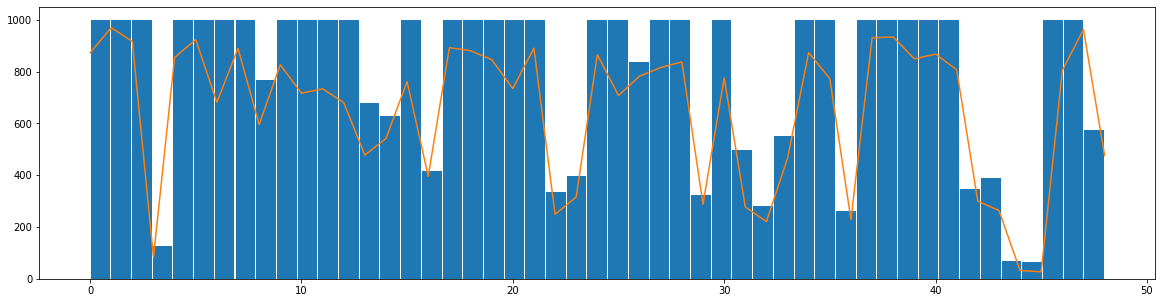

In [17]:
eval_model(new_model, test, test_y)

## Final Thoughts

We see good results from the fine-tuning, but one point is worth consideration: our first attempt at ResNet is nowhere near as good as our second. Why?

This really comes down to our last couple of layers, which are:
* An average pooling of the final convolution filters
* A dense layer to get the output

In our VGG networks we have 2 (or more) dense layers to learn our how to map the convolutional features to the output. With ResNet, we don't. As such, merely replacing the last layer and training only that doesn't work that well. If we had an extra dense layer in there, or allowed all of the last Residual block to be trained (or just fine-tune the lot), we do a lot better.